# Model Free Analysis

Statistical inquiry into the aggregate behaviour of the *Wisconsin Sorting* & *NBack* Tasks.


---------
```
Zach Wolpe
zachcolinwolpe@gmail.com
17 July 2021
```
---------



# Executive Functions

The additional experiments are provided to gauge executive functions and computer literacy that may distinguish candidates when participating in the WCST & NBack Tasks.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import re
import sys
sys.path.append('../process data/')
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
from encode_processed_data import encode_data

In [3]:
# with open('../data objects/batch_processing_object.pkl', 'rb') as file2:
#     bp = pickle.load(file2)

# ---- fetch data object ----x
with open('../data objects/batch_processing_object_with_encodings.pkl', 'rb') as file2:
    ed = pickle.load(file2)

   
ed.__dict__.keys()

dict_keys(['raw', 'fitts_summary_stats', 'corsi_summary_stats', 'navon_summary_stats', 'nback_summary_stats', 'demographics_plot', 'demographics'])

In [4]:
ed.describe_data()



        ------------------------------------------------------------------
            self.path            : raw data loc
            self.metadata        : mturk metadata
            self.mapping         : reference table
            self.data_times      : reference times table
            self.participants    : list of participant identifiers
            self.parti_code      : list of participant codes
            self.n               : total number of samples
            self.wcst_paths      : paths to wcst  raw data
            self.nback_paths     : paths to nback raw data
            self.corsi_paths     : paths to corsi raw data
            self.fitts_paths     : paths to fitts raw data
            self.navon_paths     : paths to navon raw data
            self.wcst_data       : wcst  dataframe
            self.nback_data      : nback dataframe
            self.corsi_data      : corsi dataframe
            self.fitts_data      : fitts dataframe
            self.navon_data    

In [5]:
ed.clean_data_info()



                WCST - Wisconsin Card Sorting Task                                                  DataFrame: ed.raw.wcst_date
            ---------------------------------------------------------------------------------------------------------------------------
            
                participant                     : key               : participant ID
                card_no                         : categorical       : the card shown
                correct_card                    : categorical       : the card that should be clicked of the top four on screen      
                correct_persevering             : categorical       : the card that would be clicked if the participant is persevering
                seq_no                          : numeric           : trial number
                rule                            : categorical       : matching rule  
                card_shape                      : categorical       : current card shape
                card_num

In [6]:
# ----- all categories descriptors -----x
cats_demographics   = ['gender_a', 'handedness_a', 'education_a', 'age_group']
cats_navon          = [('level_of_target', '')]

# ---- add numerical descriptors ----x
num_demographics = ['age_a','income_a', 'computer_hours_a', 'mean_reation_time_ms']
num_nback = [('block_number', ''), ('score', 'mean'), ('score', 'std'), ('status', 'mean'), ('status', 'std'), ('miss', 'mean'), 
            ('miss', 'std'), ('false_alarm', 'mean'), ('false_alarm', 'std'), ('reaction_time_ms', 'mean'), ('reaction_time_ms', 'std')]
num_navon = [('correct', 'mean'), ('correct',  'std'), ('too_slow', 'mean'), ('too_slow',  'std'), 
            ('reaction_time_ms', 'mean'), ('reaction_time_ms',  'std')]
num_corsi = [('highest_span',  'max'), ('status', 'mean'), ('status',  'std')]
num_fitts = [('delta', 'mean'), ('delta',  'std'), ('status', 'mean')]


# ---- user selected menus ---x

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [16]:
def compute_performance_trial_bins(n_bins=10, wcst_data=ed.raw.wcst_data):
    """Return: DataFrame capturing the performance per n_bins triasl"""

    # ---- add trial number ----x
    xx = []; df = wcst_data
    [xx.append((i%100)+1) for i in range(df.shape[0])]
    df['trial_no'] = xx 

    # ---- status==1 --> correct
    t = np.linspace(0,100,num=n_bins+1).tolist(); c=0

    for tt in t[1:]:
        c +=1
        x = df.loc[df['trial_no'] < tt,].groupby(['participant', 'status']).agg({
        'participant':              ['count'],
        'reaction_time_ms':         ['mean', 'std'],
        'perseverance_error':       ['mean'],
        'not_perseverance_error':   ['mean']
        }).reset_index()
        x['percentages'] = x[('participant', 'count')]/tt
        x['trials']      = str(round(t[c-1])) + '-' + str(round(t[c]))
        x['trials_2']    = t[c]
        if c==1:    data=x
        else:       data=data.append(other=x)

    # if x>0 --> perseverance_error > not_perseverance_error --> main error=perseverance_error
    data['main_error'] = np.where(data['perseverance_error'] - data['not_perseverance_error'] > 0, 'perserverance errors', 'non perserverance errors')

    return(data)

In [17]:
data = compute_performance_trial_bins()
data.head()

participant status participant reaction_time_ms               \
                           count             mean          std   
0    100934.0      1           9      2913.666667  1901.246170   
1    103322.0      1           8      1524.125000   714.072113   
2    103322.0      2           1      7644.000000          NaN   
3    107700.0      1           7      1640.857143   456.098465   
4    107700.0      2           2      3401.500000  1221.173411   

  perseverance_error not_perseverance_error percentages trials trials_2  \
                mean                   mean                               
0                0.0                    0.0         0.9   0-10     10.0   
1                0.0                    0.0         0.8   0-10     10.0   
2                0.0                    1.0         0.1   0-10     10.0   
3                0.0                    0.0         0.7   0-10     10.0   
4                0.0                    1.0         0.2   0-10     10.0   

                 main_error  
                             
0  non perserverance errors  
1  non perserverance errors  
2  non perserverance errors  
3  non perserverance errors  
4  non perserverance errors

In [20]:
def random_participant_sample(n=10, data=data):
    # ---- random sample of n participants ----x
    participants = np.random.choice(data[('participant', '')].unique(), n)
    sub = data.loc[data[('participant', '')].isin(participants) & (data['status']==1),:]
    return(sub)

In [21]:
sub = random_participant_sample()
sub.head()

participant status participant reaction_time_ms              \
                             count             mean         std   
79     230048.0      1           1      4234.000000         NaN   
162    397451.0      1           8      1742.750000  895.607814   
166    406595.0      1           4      2205.500000  567.970363   
218    469441.0      1           9      1237.111111  257.407481   
227    491090.0      1           7      1696.142857  649.726206   

    perseverance_error not_perseverance_error percentages trials trials_2  \
                  mean                   mean                               
79                 0.0                    0.0         0.1   0-10     10.0   
162                0.0                    0.0         0.8   0-10     10.0   
166                0.0                    0.0         0.4   0-10     10.0   
218                0.0                    0.0         0.9   0-10     10.0   
227                0.0                    0.0         0.7   0-10     10.0   

                   main_error  
                               
79   non perserverance errors  
162  non perserverance errors  
166  non perserverance errors  
218  non perserverance errors  
227  non perserverance errors

# Todo

### Visuals | Groups

- Function: WCST Performance plot
- Function: Heatmap plots
- Function: Pie Chart (Group)
- Function: QQ-plots
- Function: ANOVA
- Function: Summary stats (Groups)

### Groups

- Function: Select Groups
- DASH: Select Groups



In [11]:
colours={'perserverance errors':'darkred', 'non perserverance errors': 'steelblue'}




# ---- random sample of n participants ----x
participants = np.random.choice(data[('participant', '')].unique(), 10)
sub = data.loc[data[('participant', '')].isin(participants) & (data['status']==1),:]

traces = []
for participant in participants:
    df    = sub.loc[(sub[('participant', '')] == participant), ['trials_2', 'percentages', 'main_error', 'reaction_time_ms']]
    df['participant'] = participant
    trace = go.Scatter(x=df.trials_2, y=df.percentages, mode='lines+markers', name='{}'.format(participant),
            line=dict(color='black'), 
            marker=dict(
                size=df[('reaction_time_ms','mean')]/100,
                color=[colours[i] for i in df.main_error],
                opacity=0.75,
                line=dict(color='white')
                ),)
    traces.append(trace)
layout = go.Layout(title='WCST Performance', xaxis={'title':'trails'}, yaxis={'title':'% Correct'}, template='none', legend_title_text='Participant', width=900, height=500)
fig = go.Figure(data=traces, layout=layout)
fig.show()

In [32]:
sub.head()

participant status participant reaction_time_ms              \
                             count             mean         std   
79     230048.0      1           1      4234.000000         NaN   
162    397451.0      1           8      1742.750000  895.607814   
166    406595.0      1           4      2205.500000  567.970363   
218    469441.0      1           9      1237.111111  257.407481   
227    491090.0      1           7      1696.142857  649.726206   

    perseverance_error not_perseverance_error percentages trials trials_2  \
                  mean                   mean                               
79                 0.0                    0.0         0.1   0-10     10.0   
162                0.0                    0.0         0.8   0-10     10.0   
166                0.0                    0.0         0.4   0-10     10.0   
218                0.0                    0.0         0.9   0-10     10.0   
227                0.0                    0.0         0.7   0-10     10.0   

                   main_error  
                               
79   non perserverance errors  
162  non perserverance errors  
166  non perserverance errors  
218  non perserverance errors  
227  non perserverance errors

In [46]:
s2 = sub
s2['RT'] = s2[('reaction_time_ms','mean')]
s2 = s2.groupby('trials_2').agg({
    'RT':           ['mean', 'std'],
    'percentages':  ['mean', 'std']}).reset_index()
s2

trials_2           RT             percentages          
                   mean         std        mean       std
0     10.0  2017.781305  948.372484    0.677778  0.263523
1     20.0  1756.607013  461.394910    0.661111  0.242097
2     30.0  1778.695858  370.828007    0.637037  0.226963
3     40.0  1700.166111  372.105627    0.652778  0.226193
4     50.0  1732.655891  358.060572    0.635556  0.221986
5     60.0  1689.596032  315.199667    0.638889  0.234224
6     70.0  1623.503132  331.800640    0.658730  0.246345
7     80.0  1598.967326  304.992375    0.647222  0.248100
8     90.0  1549.466431  303.538176    0.664198  0.252443
9    100.0  1479.190647  281.601844    0.687778  0.244989

In [49]:

# ---- random sample of n participants ----x
def wcst_performance_plot(data=sub, group_var=('participant', ''), mean_plot=False,
            colours={'perserverance errors':'darkred', 'non perserverance errors': 'steelblue'},
            title='WCST Performance', xaxis={'title':'trails'}, yaxis={'title':'% Correct'}, template='none', legend_title_text='Participant', width=900, height=500):


    
    groups = data[group_var].unique()
    traces = []
    for g in groups:
        df    = data.loc[(data[group_var] == g), ['trials_2', 'percentages', 'main_error', 'reaction_time_ms']]
        df['participant'] = g
        trace = go.Scatter(x=df.trials_2, y=df.percentages, mode='lines+markers', name='{}'.format(g),
                line=dict(color='black'), 
                marker=dict(
                    size=df[('reaction_time_ms','mean')]/100,
                    color=[colours[i] for i in df.main_error],
                    opacity=0.75,
                    line=dict(color='white')))
        traces.append(trace)
    

    if mean_plot:
        s2 = data
        s2['RT'] = s2[('reaction_time_ms','mean')]
        s2 = s2.groupby('trials_2').agg({
            'RT':           ['mean', 'std'],
            'percentages':  ['mean', 'std']}).reset_index()

        df = s2
        g  = 'aggregate'
        df['participant'] = g
        trace = go.Scatter(x=df.trials_2, y=df[('percentages','mean')], mode='lines+markers', name='{}'.format(g),
                line=dict(color='black'), 
                marker=dict(
                    size=df[('RT','mean')]/100,
                    color='darkred',
                    opacity=0.75,
                    line=dict(color='white')))
        traces.append(trace)

    layout  = go.Layout(title=title, xaxis=xaxis, yaxis=yaxis, template=template, legend_title_text=legend_title_text, width=width, height=height)
    fig     = go.Figure(data=traces, layout=layout)
    return(fig)

wcst_fig = wcst_performance_plot(mean_plot=True)
wcst_fig

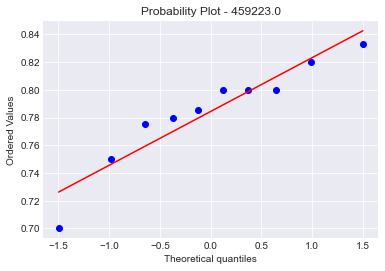

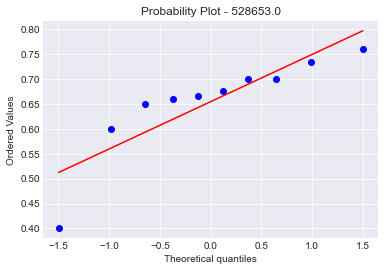

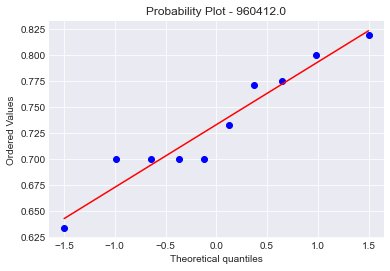

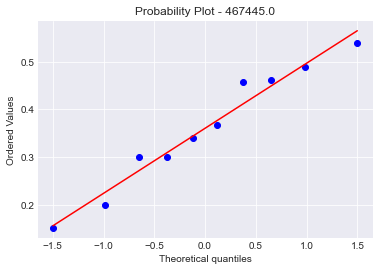

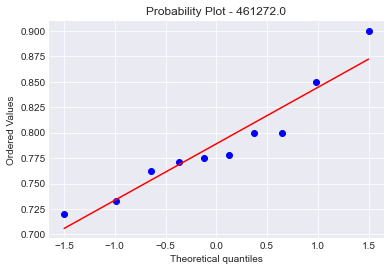

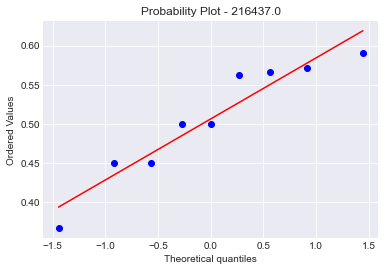

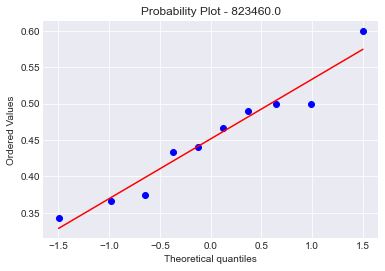

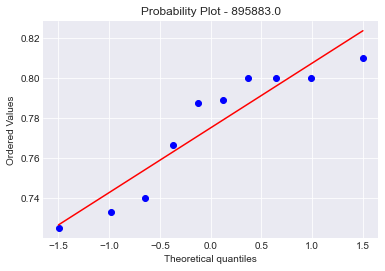

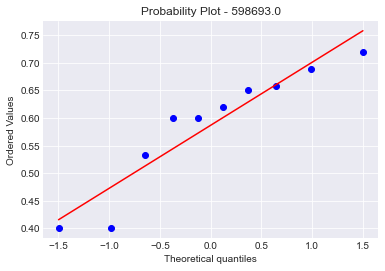

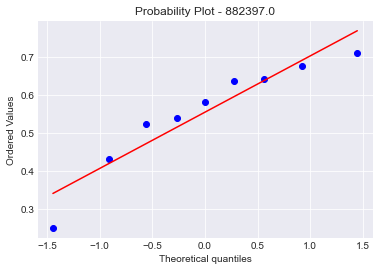

In [13]:

# ANOVA
# https://towardsdatascience.com/anova-test-with-python-cfbf4013328b



import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt



for p in participants:
    stats.probplot(sub[sub[('participant', '')]==p]['percentages'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  str(p))
    plt.show()

In [14]:
sub.shape

import plotly.figure_factory as ff
import numpy as np



# group_labels = ['Group 1', 'Group 2', 'Group 3']
# colors = ['#A56CC1', '#A6ACEC', '#63F5EF']

# # Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, colors=colors,
                         bin_size=.2, show_rug=False)

# Add title
fig.update_layout(title_text='Hist and Curve Plot')
fig.show()

NameError: name 'hist_data' is not defined

In [15]:

RTs = []
for p in participants:
    x = sub.loc[sub[('participant','')]==p,][('reaction_time_ms', 'mean')]
    RTs.append(x)

In [16]:
sub.loc[sub[('participant','')]==172230.0]

RTs = []
for p in participants:
    x = data.loc[data[('participant','')]==p,][('reaction_time_ms', 'mean')]
    RTs.append(x)

# # Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(RTs, participants, #colors=colors,
                        bin_size=200, show_rug=False
                         )

# Add title
fig.update_layout(title_text='Reaction Time Distributions')
fig.show()

In [17]:
from plotly.colors import n_colors

def violin_distribution_plot(group_var=('participant',''), groups=participants, value_var=('reaction_time_ms', 'mean'), 
    colors=n_colors('rgb(200, 10, 10)', 'rgb(5, 200, 200)', 10, colortype='rgb'),
    title='Reaction Time Distributions', xaxis={'title':'participants'}, yaxis={'title':'Reaction Times'}, template='plotly_white', legend_title_text='Participant', width=700, height=500):
    
    # ---- extract data ----x
    RTs = []
    for g in groups:
        x = data.loc[data[group_var]==g,][value_var]
        RTs.append(x)

    # ---- sort lists ----x
    srt = np.argsort([np.mean(r) for r in RTs])
    RT = [RTs[s] for s in srt]

    # ---- create figure: violin plots ----x
    traces = []
    for rt in range(len(RT)):
        traces.append(go.Violin(y=RT[rt],
                                name=groups[rt],
                                box_visible=True,
                                meanline_visible=True))

    layout = go.Layout(title=title, xaxis=xaxis, yaxis=yaxis, template=template, legend_title_text=legend_title_text, width=width, height=height)
    fig = go.Figure(data=traces, layout=layout)

    # ---- create figure: distribution plots ----x
    fig_2 = go.Figure()
    for data_line, color, grp in zip(RT, colors, groups):
        fig_2.add_trace(go.Violin(x=data_line, line_color=color, name=grp))


    fig_2.update_traces(orientation='h', side='positive', width=3, points=False)
    fig_2.update_layout(xaxis_showgrid=False, xaxis_zeroline=False, title=title, yaxis=xaxis, xaxis=yaxis, template=template, legend_title_text=legend_title_text, width=width, height=height)


    return({'data':zip(groups, RTs), 'violin_plot':fig, 'distribution_plot':fig_2})


In [18]:
# ---- Reaction Time Plots ----x
RTs = violin_distribution_plot()
RTs['violin_plot']

In [19]:
RTs['distribution_plot']

In [20]:
 performance = violin_distribution_plot(group_var=('participant',''), groups=participants, value_var='percentages', title='Performance Distributions', 
                                        xaxis={'title':'participants'}, yaxis={'title':'% Correct'})
performance['violin_plot']

In [21]:
performance['distribution_plot']

In [33]:
data.tail()

participant status participant reaction_time_ms               \
                             count             mean          std   
665    996407.0      1          64      1189.859375   482.186484   
666    996407.0      2          35      1165.885714   468.933130   
667    998593.0      1          64      2898.187500  1283.695631   
668    998593.0      2          31      3669.064516  1744.578381   
669    998593.0      3           4      8994.750000  2010.500000   

    perseverance_error not_perseverance_error percentages  trials trials_2  \
                  mean                   mean                                
665           0.000000               0.000000        0.64  90-100    100.0   
666           0.114286               0.885714        0.35  90-100    100.0   
667           0.000000               0.000000        0.64  90-100    100.0   
668           0.032258               0.967742        0.31  90-100    100.0   
669           0.250000               0.750000        0.04  90-100    100.0   

                   main_error  
                               
665  non perserverance errors  
666  non perserverance errors  
667  non perserverance errors  
668  non perserverance errors  
669  non perserverance errors

In [40]:


fig = px.density_heatmap(x=data[('reaction_time_ms','mean')], y=data['percentages'], title='Performance by Mean of Reaction Time',  
    labels={
        'x': 'Std Reaction Time',
        'y': '% Correct'}
        )
fig.show()



fig = px.density_heatmap(x=data[('reaction_time_ms','std')], y=data['percentages'], title='Performance by Std of Reaction Time',  
    labels={
        'x': 'Std Reaction Time',
        'y': '% Correct'}
        )
fig.show()

In [153]:
sub.head()

participant status participant reaction_time_ms               \
                             count             mean          std   
39     172230.0      1           3      2688.666667  1046.621867   
143    359845.0      1           9      1086.555556   290.490151   
171    414065.0      1           7      2501.000000  1002.502037   
267    562945.0      1           4      3867.500000  1313.059912   
277    586518.0      1           6      1698.333333  1330.581327   

    perseverance_error not_perseverance_error percentages trials trials_2  \
                  mean                   mean                               
39                 0.0                    0.0         0.3   0-10     10.0   
143                0.0                    0.0         0.9   0-10     10.0   
171                0.0                    0.0         0.7   0-10     10.0   
267                0.0                    0.0         0.4   0-10     10.0   
277                0.0                    0.0         0.6   0-10     10.0   

                   main_error  
                               
39   non perserverance errors  
143  non perserverance errors  
171  non perserverance errors  
267  non perserverance errors  
277  non perserverance errors

In [162]:

# Create ANOVA backbone table
raw_data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(raw_data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = sub['percentages'].mean()
SSTR = sub.groupby(('participant', '')).count() * (sub.groupby(('participant', '')).mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['percentages'].sum()

# calculate SSE and update anova table
SSE = (sub.groupby(('participant', '')).count() - 1) * sub.groupby(('participant', '')).std()**2
anova_table['SS']['Within Groups'] = SSE['percentages'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['percentages'].sum() + SSE['percentages'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sub[('participant', '')].nunique() - 1
anova_table['df']['Within Groups'] = sub.shape[0] - sub[('participant', '')].nunique()
anova_table['df']['Total'] = sub.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,3.054919,9,0.339435,48.399824,0.0,2.260442
Within Groups,0.624171,89,0.007013,,,
Total,3.67909,98,0.037542,,,


Source of Variation
Between Groups    0.0
Within Groups        
Total                
Name: P-value, dtype: object

In [170]:
# =========================================== ANOVA == REACTION TIME ======================================================x
def ANOVA(dataframe=sub, group_var=('participant', ''), value_var='percentages'):
    # Create ANOVA backbone table
    raw_data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
    anova_table = pd.DataFrame(raw_data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
    anova_table.set_index('Source of Variation', inplace = True)

    # calculate SSTR and update anova table
    x_bar = sub[value_var].mean()
    SSTR = sub.groupby(group_var).count() * (sub.groupby(group_var).mean() - x_bar)**2
    anova_table['SS']['Between Groups'] = SSTR[value_var].sum()

    # calculate SSE and update anova table
    SSE = (sub.groupby(group_var).count() - 1) * sub.groupby(group_var).std()**2
    anova_table['SS']['Within Groups'] = SSE[value_var].sum()

    # calculate SSTR and update anova table
    SSTR = SSTR[value_var].sum() + SSE[value_var].sum()
    anova_table['SS']['Total'] = SSTR

    # update degree of freedom
    anova_table['df']['Between Groups'] = sub[group_var].nunique() - 1
    anova_table['df']['Within Groups'] = sub.shape[0] - sub[group_var].nunique()
    anova_table['df']['Total'] = sub.shape[0] - 1

    # calculate MS
    anova_table['MS'] = anova_table['SS'] / anova_table['df']

    # calculate F 
    F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
    anova_table['F']['Between Groups'] = F

    # p-value
    anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

    # F critical 
    alpha = 0.05
    # possible types "right-tailed, left-tailed, two-tailed"
    tail_hypothesis_type = "two-tailed"
    if tail_hypothesis_type == "two-tailed":
        alpha /= 2
    anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

    # Final ANOVA Table
    return(anova_table)

In [172]:
# -------- ANOVA: performance differences -----------x
ANOVA(dataframe=sub, group_var=('participant', ''), value_var='percentages')

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,3.054919,9,0.339435,48.399824,0.0,2.260442
Within Groups,0.624171,89,0.007013,,,
Total,3.67909,98,0.037542,,,


In [173]:
# -------- ANOVA: RT differences -----------x
ANOVA(dataframe=sub, group_var=('participant', ''), value_var=('reaction_time_ms', 'mean'))

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,27070094.984024,9,3007788.331558,32.528836,0.0,2.260442
Within Groups,8229411.064894,89,92465.292864,,,
Total,35299506.048918,98,360199.041315,,,


In [44]:
sub.head(

participant status participant reaction_time_ms               \
                            count             mean          std   
16    130501.0      1           3      2314.333333   886.794978   
17    130501.0      2           5      4441.400000  3199.832464   
18    130501.0      3           1     10000.000000          NaN   
25    140183.0      1           5      4463.400000  2293.294421   
26    140183.0      2           4      2839.750000  1241.364135   

   perseverance_error not_perseverance_error percentages trials trials_2  \
                 mean                   mean                               
16                0.0                    0.0         0.3   0-10     10.0   
17                0.0                    1.0         0.5   0-10     10.0   
18                0.0                    1.0         0.1   0-10     10.0   
25                0.0                    0.0         0.5   0-10     10.0   
26                0.0                    1.0         0.4   0-10     10.0   

                  main_error  
                              
16  non perserverance errors  
17  non perserverance errors  
18  non perserverance errors  
25  non perserverance errors  
26  non perserverance errors

In [43]:

participants        = []
reaction_times      = []
reaction_times_std  = []
percentages         = []
for d in dfs:
    percentages.append(d.percentages.mean())
    reaction_times.append(d[('reaction_time_ms', 'mean')].mean())
    reaction_times_std.append(d[('reaction_time_ms', 'std')].mean())
    participants.append(d.participant.iloc[0])


means = pd.DataFrame(data={'participants':participants, 'reaction_times':reaction_times, 'reaction_times_std':reaction_times_std, 'percentages':percentages}, columns=['participants', 'reaction_times', 'reaction_times_std', 'percentages'])
means


,participants,reaction_times,reaction_times_std,percentages
0,895200.0,1420.870595,626.707364,0.844825
1,869019.0,2850.671413,1306.993333,0.525992
2,379824.0,2754.727420,2000.316639,0.553694
3,359845.0,1017.406371,306.912354,0.861615
4,657902.0,1798.036638,492.931855,0.681091
5,216377.0,1268.671527,694.417585,0.715274
6,226288.0,1354.286305,651.931170,0.684750
7,644865.0,1342.148059,414.443580,0.831274
8,826698.0,1534.383745,1201.250353,0.838369
9,528041.0,1742.218827,767.026733,0.535147


In [24]:
data[data[('participant', '')]==p]['percentages'].mean()
participants
sub = data.loc[data[('participant', '')].isin(participants),:]
sub.head()

participant status participant reaction_time_ms              \
                             count             mean         std   
63     216377.0      1           8      1109.625000  163.777669   
64     216377.0      2           1      2940.000000         NaN   
74     226288.0      1           7      1627.142857  663.626257   
75     226288.0      2           2      1472.000000  158.391919   
143    359845.0      1           9      1086.555556  290.490151   

    perseverance_error not_perseverance_error percentages trials trials_2  \
                  mean                   mean                               
63                 0.0                    0.0         0.8   0-10     10.0   
64                 0.0                    1.0         0.1   0-10     10.0   
74                 0.0                    0.0         0.7   0-10     10.0   
75                 0.0                    1.0         0.2   0-10     10.0   
143                0.0                    0.0         0.9   0-10     10.0   

                   main_error  
                               
63   non perserverance errors  
64   non perserverance errors  
74   non perserverance errors  
75   non perserverance errors  
143  non perserverance errors

In [32]:
sub.groupby(('participant', '')).agg({'percentages': ['mean']})

,percentages
,mean
"(participant, )",
216377.0,0.485355
226288.0,0.485355
359845.0,0.510900
379824.0,0.323570
528041.0,0.441232
644865.0,0.510900
657902.0,0.485355
826698.0,0.510900


In [ ]:



# ======================== ANOVA ===========================
# Create ANOVA backbone table
raw_data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(raw_data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)


# calculate SSTR and update anova table
x_bar = means.percentages.mean()
SSTR  = 10 * (means.percentages - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR.sum()

# calculate SSE and update anova table
SSE = (sample_df.groupby('major').count() - 1) * sample_df.groupby('major').std()**2
anova_table['SS']['Within Groups'] = SSE['salary'].sum()


In [ ]:




# calculate SSTR and update anova table
SSTR = SSTR['salary'].sum() + SSE['salary'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sample_df['major'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['major'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

In [641]:
d.participant.iloc[0]

869266.0

In [390]:
traces = []
for participant in np.random.choice(data[('participant', '')].unique(), 5):
    df = data.loc[(data[('participant', '')] == participant) & (data['status']==1), ['trials_2', 'percentages', 'reaction_time_ms']]
    df['upper'] = df[('reaction_time_ms', 'mean')] + df[('reaction_time_ms', 'std')]
    df['lower'] = df[('reaction_time_ms', 'mean')] - df[('reaction_time_ms', 'std')]
    trace = go.Scatter(x=df[('reaction_time_ms', 'mean')], y=df.percentages, mode='markers',  
    error_x=dict(
            type='data',
            symmetric=False,
            array=df.upper,
            arrayminus=df.lower)
            )
    traces.append(trace)
fig = go.Figure(data=traces)
fig.show()

25

In [84]:
data

NameError: name 'data' is not defined

# Final Datasets

These curated datasets are now joined, pruned & transformed to produce the `final` set of datasets - on which we will conduct our anaylsis.


# Structure

#### wcst


In [12]:
ed.demographics.head()

,participant,age_a,gender_a,handedness_a,education_a,income_a,computer_hours_a,age_group,mean_reation_time_ms
0,816404.0,28.0,female,right,university,6.0,20.0,25-34,5502.000000
1,221478.0,25.0,female,right,graduate school,7.0,60.0,18-24,12353.428571
2,192208.0,29.0,male,right,university,6.0,5.0,25-34,8302.285714
3,803102.0,47.0,male,right,university,7.0,74.0,45-54,10340.857143
4,844810.0,32.0,female,right,university,6.0,22.0,25-34,6612.428571


In [185]:
# ed.demographics.head()
# ed.nback_summary_stats.head()
# ed.navon_summary_stats.head()
# ed.corsi_summary_stats.head()
# ed.fitts_summary_stats.head()

participant   delta             status          
                 mean         std   mean       std
0    100934.0   -5.70  186.607130    1.0  0.000000
1    103322.0 -203.05  174.308400    1.0  0.000000
2    107700.0 -342.65  345.637059    1.1  0.447214
3    117200.0  -85.05  156.117188    1.0  0.000000
4    117306.0 -141.80  167.808036    1.0  0.000000

In [152]:
# --- demographics dataset ---x
wcst = ed.raw.wcst_data[['participant', 'card_no', 'seq_no', 'rule', 'card_shape', 'card_number', 'card_colour', 'reaction_time_ms', 'status',
                                    'card_selected', 'error','perseverance_error', 'not_perseverance_error']]
wcst.set_index('participant').join(ed.demographics.set_index('participant'))


,card_no,seq_no,rule,card_shape,card_number,card_colour,reaction_time_ms,status,card_selected,error,perseverance_error,not_perseverance_error,age_a,gender_a,handedness_a,education_a,income_a,computer_hours_a,age_group,mean_reation_time_ms
participant,,,,,,,,,,,,,,,,,,,,
100934.0,52,1,shape,triangle,1,yellow,4567,1,1,0,0,0,28.0,male,right,university,7.0,25.0,25-34,11453.571429
100934.0,59,2,shape,triangle,3,red,4661,1,3,0,0,0,28.0,male,right,university,7.0,25.0,25-34,11453.571429
100934.0,23,3,shape,cross,2,red,1319,1,2,0,0,0,28.0,male,right,university,7.0,25.0,25-34,11453.571429
100934.0,52,4,shape,triangle,1,yellow,2336,1,1,0,0,0,28.0,male,right,university,7.0,25.0,25-34,11453.571429
100934.0,52,5,shape,triangle,1,yellow,6634,1,1,0,0,0,28.0,male,right,university,7.0,25.0,25-34,11453.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998593.0,61,2,color,triangle,4,blue,2489,1,4,0,0,0,25.0,female,right,graduate school,8.0,72.0,18-24,9284.714286
998593.0,14,3,color,circle,4,green,2193,1,4,0,0,0,25.0,female,right,graduate school,8.0,72.0,18-24,9284.714286
998593.0,14,4,color,circle,4,green,2310,1,4,0,0,0,25.0,female,right,graduate school,8.0,72.0,18-24,9284.714286


In [169]:
# --- demographics dataset ---x
# ed.nback_summary_stats
# ed.fitts_summary_stats

In [61]:
# ---- Scatter Plots ----x

# --- data ---x
df1 = ed.raw.wcst_data[['participant', 'seq_no', 'card_no', 'rule', 'card_shape', 'card_number',
                        'card_colour', 'reaction_time_ms',
                        'status', 'card_selected', 'error','perseverance_error', 'not_perseverance_error']]
df2 = ed.demographics[[ 'participant', 'age_a','gender_a','handedness_a','education_a', 'income_a', 
                        'computer_hours_a','age_group']]
df  = df1.set_index('participant').join(df2.set_index('participant'))


# --- scatter plot ---x
trace_1 = go.Scatter(x=df.computer_hours_a, y=df.age_a, mode='markers', marker=dict(size=12, color='steelblue', symbol='pentagon', line={'width':2}))
data    = [trace_1]
layout  = go.Layout(title='title', xaxis={'title':'age'}, yaxis={'title':'computer hours'}, hovermode='closest')
fig     = go.Figure(data=data, layout=layout)
pyo.plot(fig, filename='temp-plot.html')

'temp-plot.html'

In [66]:
# ---- line plot ----x
trace_1 = go.Scatter(x=df.seq_no, y=df.gender_a, mode='markers', marker=dict(size=5, color='darkblue', symbol='circle'))
trace_2 = go.Scatter(x=df.seq_no, y=df.education_a, mode='markers', marker=dict(size=5, color='darkblue', symbol='circle'))

data    = [trace_1, trace_2]
layout  = go.Layout(title='R Time', xaxis={'title':'age'}, yaxis={'title':'computer hours'})
fig = go.Figure(data=data, layout=layout)
pyo.plot(fig)


'temp-plot.html'